<a href="https://colab.research.google.com/github/plodha/CMPE-297-DeepLearning/blob/main/Notebook/f_AnoGAN_Inference_Metric_AllCat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install torch==1.4.0 torchvision==0.5.0 tqdm opencv-python Pillow==8.0.1 tensorboardX==1.4

In [ ]:
!nvidia-smi

In [ ]:
!ls

In [ ]:
import argparse
import os
import numpy as np
import math
import sys
import random
#import torchvision.transforms as transforms
from torchvision.utils import save_image
#from dataloader.dataloader import load_data
#from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
#from networks import Generator, Discriminator
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import torch
import cv2
ngpu = 1
os.makedirs("images", exist_ok=True)

## Data Loader

In [ ]:
from torch.utils.data import DataLoader, Dataset
class MURA_dataset(Dataset):
    '''
    Dataset class for MURA dataset
    Args:
        - df: Dataframe with the first columns contains the path to the images
        - root_dir: string contains path of  root directory
        - transforms: Pytorch transform operations
    '''

    def __init__(self, df, root_dir, transforms=None):
        #print("I am calling Mura dataset")
        self.df = df
        self.root_dir = root_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        #print('img_name ',img_name)
        img = cv2.imread(img_name)
        #print('img shape ',img.shape)

        if self.transforms:
            img = self.transforms(img)

        if 'negative' in img_name: label = 0
        else: label = 1

        return img, label

In [ ]:
def transform(rotation, hflip, resize, totensor, normalize, centercrop, to_pil, gray):
    options = []
    if to_pil:
        options.append(torchvision.transforms.ToPILImage())
    if gray:
        options.append(torchvision.transforms.Grayscale())
    if rotation:
        options.append(torchvision.transforms.RandomRotation(20))
    if hflip:
        options.append(torchvision.transforms.RandomHorizontalFlip())
    if centercrop:
        options.append(torchvision.transforms.CenterCrop(256))
    if resize:
        options.append(torchvision.transforms.Resize((32,32)))
    if totensor:
        options.append(torchvision.transforms.ToTensor())
    # if True:
    #     options.append(transforms.Lambda(lambda x: (x - x.min())/(x.max()-x.min())))
    if normalize:
        options.append(torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    transform = torchvision.transforms.Compose(options)
    return transform

In [ ]:
def customDf(path, studyClass=None, studyType=None):
    '''
    Function to get custom csv based on class of study and type of study
    Args:
        - path(string): path to original csv
        - studyClass(list): class of study, list must contains one of the following:
            "XR_ELBOW",
            "XR_FINGER",
            "XR_FOREARM",
            "XR_HAND",
            "XR_HUMERUS",
            "XR_SHOULDER",
            "XR_WRIST"
            if None, take all
        - studyResult(list): Result of study, list must contains one of the following:
            "positive", "negative"
            if None, take all
    '''
    df = pd.read_csv(path, header=None)

    if studyClass:
        cond = df[0].str.contains(studyClass)
        df = df[cond]
    if studyType:
        cond = df[0].str.contains(studyType)
        df = df[cond]
    return df

In [ ]:
import pandas as pd
import torchvision
#transforms = transform(False, True, True, True, True, True, True, False)
transforms = transform(False, True, True, True, True, True, True, False)
# mura_df = customDf('/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/MURA-v1.1/train_image_paths.csv', 'XR_WRIST', 'negative')
# dataset = MURA_dataset(mura_df, '/content/drive/Shared drives/MeanSquare-Drive/Advanced-DeepLearning/', transforms)


mura_df = customDf('../datasets/MURA-v1.1/train_image_paths.csv', 'XR_HUMERUS', None) 
dataset = MURA_dataset(mura_df, '../datasets/', transforms)

In [ ]:
len(dataset)

1272

In [ ]:
!ls ../datasets/MURA-v1.1/

In [ ]:
len(valid_dataset)

## Checking size

In [ ]:
arr = ["XR_ELBOW","XR_FINGER","XR_FOREARM","XR_HAND","XR_HUMERUS","XR_SHOULDER","XR_WRIST"]
labels = ["positive", "negative"]
for a in arr:
    for l in labels:
        mura_df = customDf('../datasets/MURA-v1.1/train_image_paths.csv', a, l)
        dataset = MURA_dataset(mura_df, '../datasets/', transforms)
        print(a,' - ',l,' - ', len(dataset))
    print(' -------------- ')

for l in labels:
    mura_df = customDf('../datasets/MURA-v1.1/train_image_paths.csv', None, l)
    dataset = MURA_dataset(mura_df, '../datasets/', transforms)
    print('Total ',l,' - ', len(dataset))

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset=dataset,batch_size=64,shuffle=True,num_workers=4,drop_last=False)

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, dim, zdim, nc):
        super(Generator, self).__init__()
        self.nc = nc
        self.dim = dim
        preprocess = nn.Sequential(
            nn.Linear(zdim, 4 * 4 * 4 * dim),
            nn.BatchNorm1d(4 * 4 * 4 * dim),
            nn.ReLU(True),
        )

        block1 = nn.Sequential(
            nn.ConvTranspose2d(4 * dim, 2 * dim, 2, stride=2),
            nn.BatchNorm2d(2 * dim),
            nn.ReLU(True),
        )
        block2 = nn.Sequential(
            nn.ConvTranspose2d(2 * dim, dim, 2, stride=2),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
        )
        deconv_out = nn.ConvTranspose2d(dim, nc, 2, stride=2)

        self.preprocess = preprocess
        self.block1 = block1
        self.block2 = block2
        self.deconv_out = deconv_out
        self.tanh = nn.Tanh()

    def forward(self, input):
        output = self.preprocess(input)
        output = output.view(-1, 4 * self.dim, 4, 4)
        output = self.block1(output)
        output = self.block2(output)
        output = self.deconv_out(output)
        output = self.tanh(output)
        return output.view(-1, self.nc, 32, 32)

## Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, dim, zdim, nc, out_feat=False):
        super(Discriminator, self).__init__()
        self.nc = nc
        self.dim = dim
        main = nn.Sequential(
            nn.Conv2d(nc, dim, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(dim, 2 * dim, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(2 * dim, 4 * dim, 3, 2, padding=1),
            nn.LeakyReLU(),
        )
        self.out_feat=out_feat
        self.main = main
        self.linear = nn.Linear(4*4*4*dim, 1)

    def forward(self, input):
        output = self.main(input)
        output = output.view(-1, 4*4*4*self.dim)
        if self.out_feat:
            return output
        output = self.linear(output)
        return output


class Encoder(nn.Module):
     def __init__(self,dim, zdim, nc):
         super(Encoder, self).__init__()
         self.dim = dim
         main = nn.Sequential(
            nn.Conv2d(nc, dim, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(dim, 2 * dim, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(2 * dim, 4 * dim, 3, 2, padding=1),
            nn.LeakyReLU(),
            )
         self.main = main
         self.linear = nn.Linear(4*4*4*dim, zdim)

     def forward(self, input):
         output = self.main(input)
         output = output.view(-1, 4*4*4*self.dim)
         output = self.linear(output)
         return output

## Program in colab

In [ ]:
def main(n_epochs, batch_size, lr, b1, b2, n_cpu, latent_dim, img_size, channels, sample_interval, abnormal_class, device, out):
  os.makedirs(out, exist_ok=True)
  img_shape = (channels, img_size, img_size)


  # Loss weight for gradient penalty
  lambda_gp = 10

  # Initialize generator and discriminator
  generator = Generator(dim = 64, zdim=latent_dim, nc=channels)
  discriminator = Discriminator(dim = 64, zdim=latent_dim, nc=channels)

  generator.to(device)
  discriminator.to(device)

  # Configure data loader
  dataloader = torch.utils.data.DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=4,
                                           drop_last=False)

  # Optimizers
  optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
  optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

  Tensor = torch.cuda.FloatTensor if device == 'cuda' else torch.FloatTensor

  def compute_gradient_penalty(D, real_samples, fake_samples):
      """Calculates the gradient penalty loss for WGAN GP"""
      #print(real_samples.size(0),fake_samples.size(0))
      # Random weight term for interpolation between real and fake samples
      alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
      # Get random interpolation between real and fake samples
      interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
      d_interpolates = D(interpolates)
      fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
      # Get gradient w.r.t. interpolates
      gradients = autograd.grad(
          outputs=d_interpolates,
          inputs=interpolates,
          grad_outputs=fake,
          create_graph=True,
          retain_graph=True,
          only_inputs=True,
      )[0]
      gradients = gradients.view(gradients.size(0), -1)
      gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
      return gradient_penalty

  # ----------
  #  Training
  # ----------

  batches_done = 0
  for epoch in range(n_epochs):
      #print("I made it")
      if epoch % 100 == 0: print("processing :",(epoch),' / ',n_epochs)  
      for i, data in enumerate(dataloader):
          imgs, _ = data

          # Configure input
          real_imgs = Variable(imgs.type(Tensor))

          # ---------------------
          #  Train Discriminator
          # ---------------------

          optimizer_D.zero_grad()

          # Sample noise as generator input
          z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

          # Generate a batch of images
          fake_imgs = generator(z)

          # Real images
          real_validity = discriminator(real_imgs)
          # Fake images
          fake_validity = discriminator(fake_imgs)
          #print("real: ", real_imgs.data.shape)
          #print("fake: ", fake_imgs.data.shape)
          # Gradient penalty
          gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
          # Adversarial loss
          d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

          d_loss.backward()
          optimizer_D.step()

          optimizer_G.zero_grad()

          fake_imgs = generator(z)
          # Loss measures generator's ability to fool the discriminator
          # Train on fake images`
          fake_validity = discriminator(fake_imgs)
          g_loss = -torch.mean(fake_validity)

          g_loss.backward()
          optimizer_G.step()

          if batches_done % sample_interval == 0:
              
              save_image(fake_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
#           if (epoch % 100 == 0) and (batches_done % sample_interval == 0):
#               print(
#                   "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
#                   % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
#               )

          batches_done += 1
      if epoch % 200 ==0:
            
            torch.save(generator.state_dict(), os.path.join(out, 'G_epoch{}.pt'.format(epoch)))
            torch.save(discriminator.state_dict(), os.path.join(out, 'D_epoch{}.pt'.format(epoch)))
            
            
    
     

In [ ]:
from tqdm import tqdm

In [ ]:
n_epochs = 10001
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 128
img_size = 64
channels = 3
sample_interval = 100
abnormal_class = 0
device = 'cuda' 
out = '../anoGAN-ckpts-XR_HUMERUS1/'
if not os.path.exists(out): os.mkdir(out)
    


In [ ]:
main(n_epochs, batch_size, lr, b1, b2, n_cpu, latent_dim, img_size, channels, sample_interval, abnormal_class, device, out)

processing : 0  /  5001
processing : 100  /  5001
processing : 200  /  5001
processing : 300  /  5001
processing : 400  /  5001
processing : 500  /  5001
processing : 600  /  5001
processing : 700  /  5001
processing : 800  /  5001
processing : 900  /  5001
processing : 1000  /  5001
processing : 1100  /  5001
processing : 1200  /  5001
processing : 1300  /  5001
processing : 1400  /  5001
processing : 1500  /  5001
processing : 1600  /  5001
processing : 1700  /  5001
processing : 1800  /  5001
processing : 1900  /  5001
processing : 2000  /  5001
processing : 2100  /  5001
processing : 2200  /  5001
processing : 2300  /  5001
processing : 2400  /  5001


# Inference

In [ ]:
# change the path here to shared drive

mura_valid_df = customDf('../datasets/MURA-v1.1/valid_image_paths.csv', 'XR_HUMERUS', None)    #scs
valid_dataset = MURA_dataset(mura_valid_df, '../datasets/', transforms)

In [ ]:
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,batch_size=64,shuffle=True,num_workers=4,drop_last=False)

In [ ]:
from PIL import Image
import numpy as np

In [ ]:

def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.

    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)

(32, 32, 3)
(32, 32, 3)
torch.Size([288])
0.4028211478410681
0.4028211478410681
288


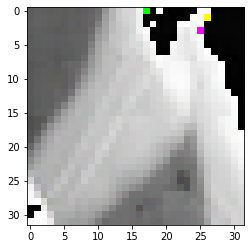

In [ ]:


n_epochs = 5001
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 128
img_size = 64
channels = 3
sample_interval = 100
abnormal_class = 0
device = 'cuda' 
out = '../anoGAN-ckpts-XR_HUMERUS/'  # change scs for each category

img_shape = (channels, img_size, img_size)
max_auc = 0


generator = Generator(dim = 64, zdim=latent_dim, nc=channels)
discriminator = Discriminator(dim = 64, zdim=latent_dim, nc=channels,out_feat=True)
encoder = Encoder(dim = 64, zdim=latent_dim, nc=channels)

generator.load_state_dict(torch.load(out+'G_epoch5000.pt'))
discriminator.load_state_dict(torch.load(out+'D_epoch5000.pt'))
generator.to(device)
encoder.to(device)
discriminator.to(device)
with torch.no_grad():
    labels = torch.zeros(size=(len(valid_dataloader.dataset),),
                                        dtype=torch.long, device=device)

    scores = torch.empty(
                size=(len(valid_dataloader.dataset),),
                dtype=torch.float32,
                device=device)
    for i, (imgs, lbls) in enumerate(valid_dataloader):
            imgs = imgs.to(device)
            lbls = lbls.to(device)

            labels[i*batch_size:(i+1)*batch_size].copy_(lbls)
            emb_query = encoder(imgs)
            fake_imgs = generator(emb_query)

            image_feats  = discriminator(imgs)
            recon_feats = discriminator(fake_imgs)
                
            diff = imgs-fake_imgs
            
            image1_tensor= diff[0]
           
            im = tensor2im(imgs)
            plt.imshow(im)
            
            im2 = tensor2im(fake_imgs)
            plt.imshow(im2)
            
            im3 = tensor2im(diff)
            plt.imshow(im3)
            print(im.shape)
            print(im3.shape)
            #break    # comment
            
            image_distance = torch.mean(torch.pow(imgs-fake_imgs, 2), dim=[1,2,3])
            feat_distance = torch.mean(torch.pow(image_feats-recon_feats, 2), dim=1)

            # z_distance = mse_loss(emb_query, emb_fake)
            scores[i*batch_size:(i+1)*batch_size].copy_(feat_distance)

    labels = labels.cpu()
    # scores = torch.mean(scores,)
    scores = scores.cpu().squeeze()
    print(scores.shape)
    # True/False Positive Rates.
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    max_auc = max(roc_auc, max_auc)
    print(max_auc)
    
    print(len(valid_dataloader.dataset))

In [ ]:
for i in range(288):
    print(labels[i] , scores[i])
    

tensor(1) tensor(-0.0296)
tensor(0) tensor(0.0069)
tensor(0) tensor(0.0561)
tensor(0) tensor(-0.0360)
tensor(0) tensor(0.0055)
tensor(0) tensor(0.0274)
tensor(0) tensor(-0.0088)
tensor(1) tensor(0.0470)
tensor(1) tensor(-0.0400)
tensor(0) tensor(0.0186)
tensor(1) tensor(0.0556)
tensor(0) tensor(-0.0007)
tensor(1) tensor(-0.0503)
tensor(1) tensor(-0.0602)
tensor(1) tensor(0.0424)
tensor(1) tensor(-0.0457)
tensor(0) tensor(-0.0617)
tensor(1) tensor(0.0173)
tensor(1) tensor(0.0106)
tensor(1) tensor(0.0599)
tensor(1) tensor(-0.0195)
tensor(0) tensor(-0.0023)
tensor(0) tensor(0.0103)
tensor(1) tensor(-0.0014)
tensor(0) tensor(-0.0028)
tensor(0) tensor(0.0347)
tensor(0) tensor(-0.0055)
tensor(0) tensor(-0.0163)
tensor(0) tensor(-0.0212)
tensor(1) tensor(-0.0232)
tensor(1) tensor(0.0127)
tensor(0) tensor(-0.0352)
tensor(1) tensor(-0.0417)
tensor(1) tensor(0.0257)
tensor(0) tensor(0.0445)
tensor(1) tensor(0.0181)
tensor(1) tensor(0.0601)
tensor(1) tensor(-0.0487)
tensor(0) tensor(-0.0134)
tens